In [93]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression as logit # use build-in logistic regression model in sklearn
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
# Plotly plotting package
import plotly.graph_objects as go
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

from sklearn import tree
from xgboost import XGBClassifier as XGBC
from sklearn.svm import SVC

# Tools in sklearn to select best model
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

from sklearn.metrics import balanced_accuracy_score, make_scorer, roc_auc_score, accuracy_score

In [92]:
dat = pd.read_csv('sph6004_assignment1_data.csv')
# dat.shape (50920, 162)
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50920 entries, 0 to 50919
Columns: 162 entries, id to weight_admit
dtypes: float64(158), int64(2), object(2)
memory usage: 62.9+ MB


In [3]:
y = dat.iloc[:, 1]
x = dat.iloc[:, 2:] # (50920, 160)
# normalization
x_df = (x-x.mean())/x.std()
# x_df.describe().transpose()
df = pd.DataFrame(x_df, columns = x.columns)
df['gender'] = dat.loc[:, 'gender']
df['race'] = dat.loc[:, 'race']
df['aki'] = y
df['id'] = dat.iloc[:, 0]

/var/folders/k3/9vlc8xm57p59t6dm081k9t780000gn/T/ipykernel_11677/2837390933.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  x_df = (x-x.mean())/x.std()
/var/folders/k3/9vlc8xm57p59t6dm081k9t780000gn/T/ipykernel_11677/2837390933.py:4: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  x_df = (x-x.mean())/x.std()
/var/folders/k3/9vlc8xm57p59t6dm081k9t780000gn/T/ipykernel_11677/2837390933.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

In [4]:
df.dtypes

gender             object
admission_age     float64
race               object
heart_rate_min    float64
heart_rate_max    float64
                   ...   
gcs_unable        float64
height            float64
weight_admit      float64
aki                 int64
id                  int64
Length: 162, dtype: object

In [ ]:
# check correlation
round(x_df.apply(x_df.corrwith),2)

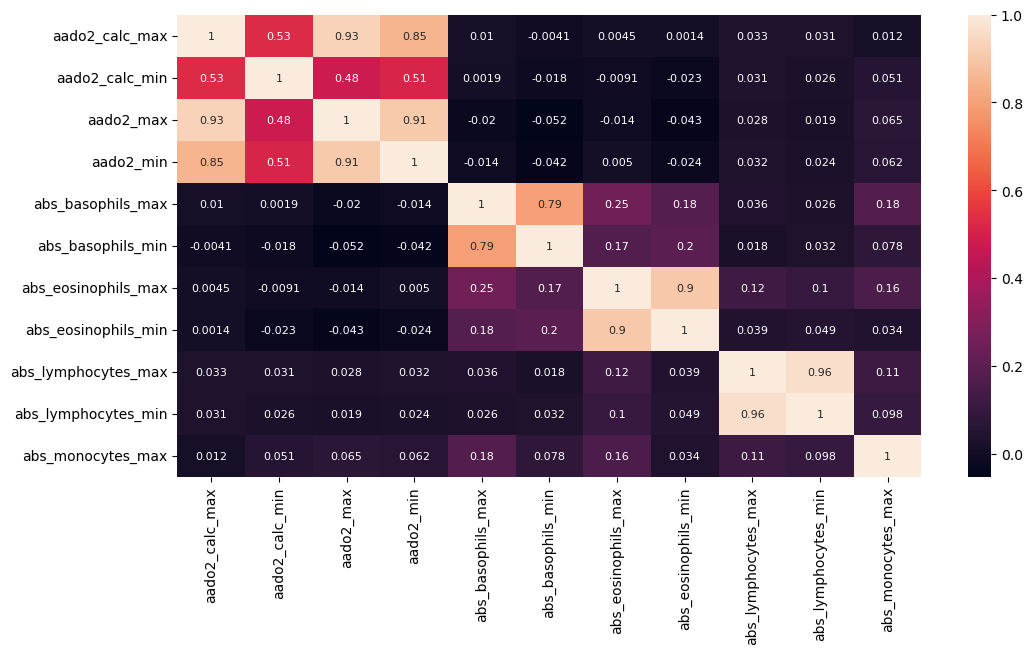

In [88]:
import seaborn as sns
var_corr = x_df.iloc[:, :11].corr()
plt.figure(figsize=[12, 6])
sns.heatmap(var_corr, annot=True, annot_kws={"fontsize":8})
plt.show()

In [6]:
na_df = df.isnull().sum()*100/len(df)
nadf_reset = na_df.reset_index()
nadf_reset.columns = ['Row Name', 'Missing Percentage']
nadf_reset

,Row Name,Missing Percentage
0,gender,0.000000
1,admission_age,0.000000
2,race,0.000000
3,heart_rate_min,0.155145
4,heart_rate_max,0.155145
...,...,...
157,gcs_unable,0.461508
158,height,50.881775
159,weight_admit,2.003142
160,aki,0.000000


In [7]:
# remove cols that have more than 70% missing
df = df.loc[:, df.columns[nadf_reset['Missing Percentage'] < 70]]
# 50 cols are removed, now 112 cols (50920, 112)

### Redefine the outcome to be binary
We redefine the outcome AKI to be: if AKI = 3, then outcome = 1; if AKI < 3, then outcome = 0

In [8]:
df['AKICat'] = np.where(df['aki'] < 3, 0, 1)

/var/folders/k3/9vlc8xm57p59t6dm081k9t780000gn/T/ipykernel_11677/2452586296.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['AKICat'] = np.where(df['aki'] < 3, 0, 1)


In [9]:
df['AKICat'].value_counts()

0    42986
1     7934
Name: AKICat, dtype: int64

In [10]:
X_df = df.iloc[:, :110]
columns_to_drop = ['race', 'gender']
X_df_dropped = X_df.drop(columns=columns_to_drop, axis=1)
Y_df = df.loc[:, 'AKICat']

### Convert string to integer

In [11]:
df['race'] = df['race'].str.split(' ').str[0]
df['race'] = df['race'].str.split('/').str[0]
race_df = pd.get_dummies(df['race'], dtype = int)
gender_df = pd.get_dummies(df['gender'], dtype = int)

X_df_full = pd.concat([X_df_dropped, race_df, gender_df], axis = 1)

### KNN Imputation for missing values

In [12]:
from sklearn.impute import KNNImputer

In [13]:
imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')
X_df_impute = imputer.fit_transform(X_df_full)

### Oversampling

In [14]:
smote_sampler = SMOTE(random_state=12,sampling_strategy='minority')
X_df_SMOTE, y_df_SMOTE = smote_sampler.fit_resample(X_df_impute, Y_df)

In [30]:
X_fin = pd.DataFrame(X_df_SMOTE)
X_fin.columns = X_df_full.columns
Y_fin = pd.DataFrame(y_df_SMOTE)
full_df = pd.concat([X_fin, Y_fin], axis=1)
full_df.to_csv('full_df.csv', index=False)

In [17]:
full_df.shape

(85972, 124)

### Split the data

In [31]:
dat1 = pd.read_csv('full_df.csv')

In [33]:
cases = ['train','test']
case_list = np.random.choice(cases, size=dat1.shape[0], replace=True, p=[0.8,0.2])
X_df = dat1.iloc[:, :123]
Y_df = dat1.iloc[:, 123]
X_df_train = X_df.iloc[case_list=='train',:]
X_df_test = X_df.iloc[case_list=='test',:]
Y_df_train = Y_df.iloc[case_list=='train']
Y_df_test = Y_df.iloc[case_list=='test']

### Forward Selection

In [42]:
model = logit(penalty='l1',C=1/10,solver='liblinear') # c: 1/(strength of L1 regularization)

sfs=SFS(model,
        n_features_to_select=20,
        direction="forward")

fs_svc = sfs.fit(X_df_train, Y_df_train)

In [51]:
feature_select = fs_svc.get_feature_names_out()
feature_select

array(['heart_rate_min', 'sbp_min', 'sbp_max', 'dbp_min',
       'temperature_min', 'spo2_mean', 'po2_min', 'pao2fio2ratio_min',
       'hemoglobin_min.1', 'albumin_min', 'aniongap_min', 'bun_max',
       'chloride_max.1', 'pt_max', 'ptt_max', 'bilirubin_total_min',
       'bilirubin_total_max', 'gcs_verbal', 'height', 'weight_admit'],
      dtype=object)

The selected 20 feature will be used for the prediction model.

In [77]:
X_train = fs_svc.transform(X_df_train)
X_test = fs_svc.transform(X_df_test)

X_train1 = pd.DataFrame(X_train)
X_train1.columns = feature_select
X_train1.reset_index(drop=True, inplace=True)
Y_df_train.reset_index(drop=True, inplace=True)
Xy_train = pd.concat([X_train1, Y_df_train], axis=1)
Xy_train.to_csv('Xy_train.csv', index=False)

X_test1 = pd.DataFrame(X_test)
X_test1.columns = feature_select
X_test1.reset_index(drop=True, inplace=True)
Y_df_test.reset_index(drop=True, inplace=True)
Xy_test = pd.concat([X_test1,Y_df_test],axis=1)
Xy_test.to_csv('Xy_test.csv', index=False)

In [78]:
Xy_test

,heart_rate_min,sbp_min,sbp_max,dbp_min,temperature_min,spo2_mean,po2_min,pao2fio2ratio_min,hemoglobin_min.1,albumin_min,...,bun_max,chloride_max.1,pt_max,ptt_max,bilirubin_total_min,bilirubin_total_max,gcs_verbal,height,weight_admit,AKICat
0,0.138491,0.213650,-0.933917,0.737670,-0.035826,-0.555198,-0.550487,-0.577769,0.739267,0.577849,...,0.185042,-2.116183,0.771510,3.700181,0.104934,0.275587,0.772550,-0.027599,0.012769,0
1,-0.654017,0.099696,-0.230225,0.737670,0.511904,0.146966,-0.207433,1.444619,-0.398804,0.898833,...,-0.838832,-0.632621,-0.426565,-0.553180,-0.337469,-0.364492,0.772550,-0.089998,-0.536861,0
2,-0.720059,1.125281,0.077640,1.078278,0.736613,-0.817943,-0.741073,-0.501255,2.490145,-0.109974,...,0.603900,-2.116183,-0.360006,-0.549750,-0.220096,-0.259162,-1.619342,0.034800,0.871738,0
3,2.516014,0.213650,-1.109840,0.397062,0.188884,-1.184881,-0.583840,-0.033199,-0.792751,-1.072926,...,1.162377,-1.951343,1.199394,0.444988,2.894780,2.754879,0.772550,-0.152396,-0.274475,0
4,-0.654017,0.954351,1.177159,-0.028698,-0.035826,0.307331,2.689471,1.806763,0.564179,1.128107,...,-0.559594,0.850942,-0.508973,-0.554323,-0.301354,-0.332083,0.772550,-0.027599,-0.426382,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17323,0.017533,-0.515175,0.422172,-0.926287,0.124486,0.246228,-0.658891,-1.154720,-0.032226,-0.700493,...,1.462976,-0.474724,-0.155562,0.514124,-0.145566,-0.187213,-1.140964,1.095511,0.059901,1
17324,0.160974,0.058884,0.509182,-0.039870,0.074138,-0.500243,-0.023774,-0.017274,0.644272,0.462723,...,-0.630724,-0.234550,-0.460239,-0.378418,-0.109191,-0.121108,0.772550,0.608116,0.711094,1
17325,-0.174652,0.062353,-0.844470,0.642306,0.484076,-1.780908,-0.501504,-0.675060,0.598931,-0.066521,...,-0.545994,-0.604220,-0.337568,0.958714,0.241950,0.267239,0.772550,0.759395,-0.015928,1
17326,1.179958,-0.581840,-1.473315,-0.011087,-0.728850,0.478713,-0.988946,-1.004388,-0.269820,-1.135108,...,0.610152,-0.464617,3.698661,0.748785,0.030838,0.254908,0.772550,-0.190048,-0.541536,1


### Model

In [101]:
nonlinear_models = {
    'DecisionTree':DTC(criterion='entropy'),
    'XGBoost':XGBC(),
    'SVM_rbf':SVC(probability=True, kernel='rbf')
}

stratifiedCV = StratifiedKFold(n_splits=8)


params = {
    'DecisionTree':{
        'max_depth':np.arange(start=1,stop=10)
    },
    'XGBoost':{
        'n_estimators':np.arange(start=2,stop=30,step=2),
        'max_depth':np.arange(start=2,stop=6),
        'learning_rate':np.arange(start=0.05,stop=0.4,step=0.05)
    },
    'SVM_rbf':{
        'C':np.arange(0.5,5,step=0.5)
    }
}

records = {}

test_acc, test_auc = [], []
for model in nonlinear_models:
    BestParams = GridSearchCV(
        nonlinear_models[model],
        param_grid = params[model],
        scoring='f1',
        cv=stratifiedCV,
        n_jobs=-1
    )
    BestParams.fit(X_train,Y_df_train)
    Xy_test[model] = BestParams.predict(X_test).astype(str)
    y_test_pred = BestParams.predict(X_test)
    y_test_prob = BestParams.predict_proba(X_test)[:, 1]
    records[model] = BestParams
    
    test_acc.append(balanced_accuracy_score(Xy_test.loc[:, 'AKICat'], y_test_pred))
    test_auc.append(roc_auc_score(Xy_test.loc[:, 'AKICat'], y_test_prob))
    
    print('For {} cross validation F1 score is {:.4f}'.format(model,BestParams.best_score_))
    print(BestParams.best_params_)

For DecisionTree cross validation F1 score is 0.7415
{'max_depth': 8}
For XGBoost cross validation F1 score is 0.8445
{'learning_rate': 0.30000000000000004, 'max_depth': 5, 'n_estimators': 22}
For SVM_rbf cross validation F1 score is 0.7938
{'C': 4.5}


In [102]:
scores_df = pd.DataFrame({'test_acc':test_acc, 
                          'test_auc':test_auc},
                         index = ['Decision Tree', 'XGBoost', 'SVM'])

In [103]:
scores_df

,test_acc,test_auc
Decision Tree,0.767790,0.853119
XGBoost,0.865974,0.934546
SVM,0.800099,0.875111
